Training accuracy: 1.0000
Validation/Test accuracy: 0.9886

Classification report (test):
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         4
           1     0.9884    1.0000    0.9942       171

    accuracy                         0.9886       175
   macro avg     0.9942    0.7500    0.8304       175
weighted avg     0.9887    0.9886    0.9867       175

ROC AUC (test): 0.989766081871345


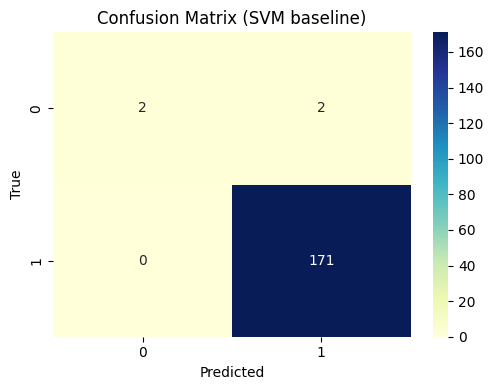

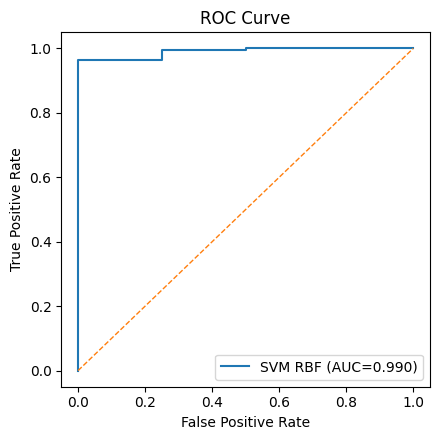


Kernel comparison (accuracy on test):
- linear : 0.9886
- poly   : 0.9886
- rbf    : 0.9886
- sigmoid: 0.9886

Best validation accuracy : 0.9886 with kernel: linear
Fitting 4 folds for each of 22 candidates, totalling 88 fits

Best params (GridSearchCV): {'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best CV ROC AUC: 0.9835189697180647

[GridSearch] Test accuracy: 0.9885714285714285
[GridSearch] Test ROC AUC: 0.9853801169590644

[GridSearch] Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         4
           1     0.9884    1.0000    0.9942       171

    accuracy                         0.9886       175
   macro avg     0.9942    0.7500    0.8304       175
weighted avg     0.9887    0.9886    0.9867       175



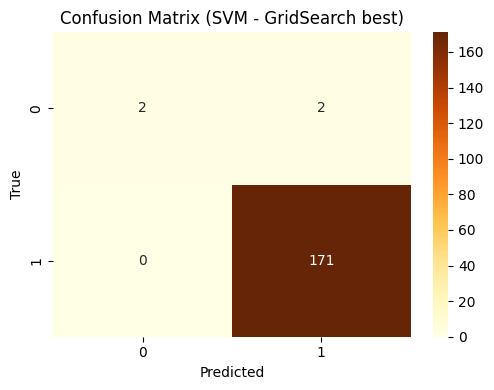

In [1]:
# ================================
# 0) IMPORT (theo 2.2.2 Bài làm mẫu)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc)

RANDOM_STATE = 101

# ================================
# 1) NẠP & CHUẨN BỊ DỮ LIỆU (bám 2.2.2 — Bước 1)
# ================================
CSV_PATH = "/kaggle/input/animal-disease/data.csv"   # <-- đổi đường dẫn nếu cần
df = pd.read_csv(CSV_PATH)

# Chuẩn hoá nhãn Dangerous (trường hợp là Yes/No hay 0/1 đều xử lý được)
if df["Dangerous"].dtype == "O":
    y = df["Dangerous"].astype(str).str.strip().str.lower().map({
        "yes":1, "y":1, "danger":1, "dangerous":1,
        "no":0, "n":0, "not danger":0, "not dangerous":0, "safe":0
    }).fillna(0).astype(int)
else:
    y = df["Dangerous"].astype(int)

text_cols = ["AnimalName", "symptoms1", "symptoms2", "symptoms3", "symptoms4", "symptoms5"]
for c in text_cols:
    if c not in df.columns:
        df[c] = ""  # nếu thiếu cột, tạo rỗng để tránh lỗi

# Gộp các cột văn bản thành một trường "text"
df["text"] = (
    df[text_cols]
    .astype(str)
    .apply(lambda s: " ".join(s.values), axis=1)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

X = df["text"].copy()

# Train/Test split 80:20 như tài liệu (stratify để giữ tỉ lệ lớp)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ================================
# 2) SVM BASELINE (giống mẫu: SVC().fit, .score)
#    - Dùng TF-IDF (1–2 grams), min_df=2 để giảm nhiễu lỗi chính tả
#    - class_weight='balanced' vì dễ lệch lớp
# ================================
svc_pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, lowercase=True)),
    ("svc", svm.SVC(kernel="rbf", C=1.0, gamma="scale",
                    probability=True, class_weight="balanced",
                    random_state=RANDOM_STATE))
])

svc_pipe.fit(X_train, y_train)

# Accuracy như tài liệu + thêm báo cáo và ROC AUC
train_acc = svc_pipe.score(X_train, y_train)
test_acc  = svc_pipe.score(X_test,  y_test)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation/Test accuracy: {test_acc:.4f}")

y_pred  = svc_pipe.predict(X_test)
y_proba = svc_pipe.predict_proba(X_test)[:,1]
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC (test):", roc_auc_score(y_test, y_proba))

# Confusion matrix (tương tự “Hình 2.5/2.6” phần mẫu)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.2,4))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix (SVM baseline)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4.5,4.5))
plt.plot(fpr, tpr, label=f"SVM RBF (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"--",lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout(); plt.show()

# ================================
# 3) SO SÁNH KERNELS (linear, poly, rbf, sigmoid) — y như vòng lặp trong tài liệu
# ================================
kernels = ["linear","poly","rbf","sigmoid"]
best_svm = None
best_val_acc = -1.0
best_kernel = None
results = []

for k in kernels:
    clf = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, lowercase=True)),
        ("svc", svm.SVC(kernel=k, probability=True,
                        class_weight="balanced", random_state=RANDOM_STATE))
    ])
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    results.append((k, acc))
    if acc > best_val_acc:
        best_val_acc = acc
        best_svm = clf
        best_kernel = k

print("\nKernel comparison (accuracy on test):")
for k, acc in results:
    print(f"- {k:7s}: {acc:.4f}")

print(f"\nBest validation accuracy : {best_val_acc:.4f} with kernel: {best_kernel}")

# ================================
# 4) (TUỲ CHỌN) GRIDSEARCHCV — đúng theo gợi ý trong tài liệu
#    Tối ưu C, gamma, degree cho các kernel phổ biến
# ================================
param_grid = [
    {"svc__kernel":["linear"], "svc__C":[0.5, 1, 3, 10]},
    {"svc__kernel":["rbf"],    "svc__C":[0.5, 1, 3, 10], "svc__gamma":["scale", 0.1, 0.01]},
    {"svc__kernel":["poly"],   "svc__C":[0.5, 1, 3],     "svc__degree":[2,3], "svc__gamma":["scale"]},
]

grid = GridSearchCV(
    estimator=Pipeline(steps=[
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, lowercase=True)),
        ("svc", svm.SVC(probability=True, class_weight="balanced",
                        random_state=RANDOM_STATE))
    ]),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=4, refit=True, n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("\nBest params (GridSearchCV):", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# Đánh giá mô hình tối ưu trên test
y_pred_gs  = grid.predict(X_test)
y_proba_gs = grid.predict_proba(X_test)[:,1]
print("\n[GridSearch] Test accuracy:", accuracy_score(y_test, y_pred_gs))
print("[GridSearch] Test ROC AUC:", roc_auc_score(y_test, y_proba_gs))
print("\n[GridSearch] Classification report:")
print(classification_report(y_test, y_pred_gs, digits=4))

cm_gs = confusion_matrix(y_test, y_pred_gs)
plt.figure(figsize=(5.2,4))
sns.heatmap(pd.DataFrame(cm_gs), annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix (SVM - GridSearch best)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
